# Generate dataset for Rayleigh model

## Generate Dataset

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

from disba import PhaseDispersion
from tqdm import tqdm

ub = np.array([0.63, 0.79, 0.88, 0.95, 1.05, 1.2 , 1.28, 1.36, 1.36, 1.4 ])
lb = np.array([0.33, 0.43, 0.48, 0.51, 0.55, 0.6 , 0.58, 0.56, 0.56, 0.6 ])

thickness = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2])
T = np.logspace(-0.5, 0.5, 14)
f = 1 / T

N_simulate = 6000

# begin generation
phase_v_data = np.zeros([N_simulate, len(f)])
Vs_data = np.zeros([N_simulate, len(thickness)])
k = 0

while (k<N_simulate):
    V_s =  np.random.normal((lb+ub)/2, (ub-lb)/4, len(lb))
    V_p = 1.16*V_s + 1.36
    rho = 1.74*(V_p**0.25)
    pd = PhaseDispersion(thickness, V_p, V_s, rho, dc=0.0001)
    
    try:
        cpr = pd(T, mode=0, wave="rayleigh")
        phase_v_data[k] = cpr[1]
        Vs_data[k] = V_s
        k += 1
        # if k % 10000 == 0:
        #     print("==> %d data" % (k))
    except:
        continue
    progress = (k + 1) / N_simulate * 100
    sys.stdout.write(f"\rProgress: [{'#' * int(progress//2):<50}] {progress:.1f}%")
    sys.stdout.flush()
print("done")

Progress: [##################################################] 100.0%done


In [3]:
np.save("model1D_normal.npy",Vs_data)
np.save("phase_normal.npy",phase_v_data)

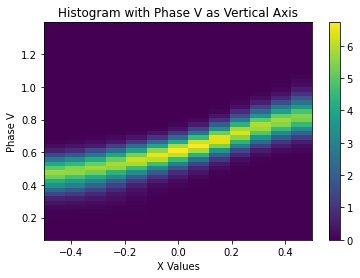

In [8]:
import numpy as np
import matplotlib.pyplot as plt

n_bins = 50  
y_value = phase_v_data
x_values = np.linspace(-0.5, 0.5, 14) 

H = np.zeros((n_bins, len(x_values) - 1)) 

for i in range(len(x_values) - 1):
    hist, _ = np.histogram(
        y_value[:, i],  
        bins=n_bins, 
        range=(y_value.min(), y_value.max()), 
        density=True
    )
    H[:, i] = hist  

fig, ax = plt.subplots()
# ax.set_xlim(0.7, 2.0)  
ax.set_ylim(y_value.min(), y_value.max())

extent = [x_values[0], x_values[-1], y_value.min(), y_value.max()]
im = ax.imshow(H, aspect='auto', extent=extent, interpolation='nearest', origin='lower')

ax.set_xlabel('X Values')
ax.set_ylabel('Phase V')
ax.set_title('Histogram with Phase V as Vertical Axis')

plt.colorbar(im, ax=ax)

plt.show()

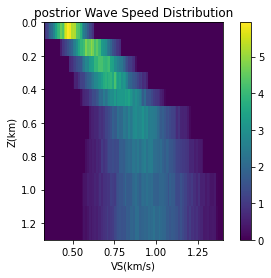

In [9]:
    depths = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 1.1, 1.3])
    x_sampled =  Vs_data[(Vs_data >= lb).all(axis=1) & (Vs_data <= ub).all(axis=1)]

    bin_widths = np.array([0.1] * 5 + [0.2] * 4)
    bin_edges = np.concatenate(([0], np.cumsum(bin_widths)))

    x_sampled_average=np.mean(x_sampled, axis=0)

    x_sampled_extended = np.hstack((
        x_sampled[:, :5],  
        np.repeat(x_sampled[:, 5:], 2, axis=1)  
    ))


    depths_extended = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3])

    n_bins= 100
    H = np.zeros((len(depths_extended) - 1, n_bins))  

    for i in range(len(depths_extended) - 1):
        hist, _ = np.histogram(x_sampled_extended[:, i], bins=n_bins, range=(x_sampled_extended.min(), x_sampled_extended.max()), density=True)
        H[i, :] = hist
 
    fig, ax = plt.subplots()
    # ax.set_xlim(0.1, 1.5)

    extent = [x_sampled_extended.min(), x_sampled_extended.max(), depths_extended[0], depths_extended[-1]]
    im = ax.imshow(H, aspect='equal', extent=extent, interpolation='nearest', origin='lower')


    ax.set_ylim(ax.get_ylim()[::-1])

    ax.set_xlabel('VS(km/s)')
    ax.set_ylabel('Z(km)')
    ax.set_title('postrior Wave Speed Distribution')

    plt.colorbar(im, ax=ax)
    
    plt.show()